# Case study on flight cancellations

### Description
A prediction tool was built using a regression decision tree on flight data from 2008 to track departure delay times of Delta Airlines from Hartsfield–Jackson Atlanta International Airport. This can then be used to track delays by an airline and to adjust the schedule to prevent more delays or to introduce penalties to compensate for the delays. 

Multiple linear regressions and a regression decision tree were built using flight data from 2008. Variables, that were used were departure delay time, scheduled departure time (from Atlanta Airport), distance, months, and weekdays. Finally, the decision tree was chosen as the recommended prediction tool because it performs slightly better than the multiple linear regression and it will be easier to apply in daily business. This should be used to track delays of Delta Airlines in the future!

## Import Libraries and Data

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pydotplus
import statsmodels.api as sm
import seaborn as sea 

from math import sqrt

from IPython.display import Image  
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression 

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
    
#import data
df = pd.read_csv('~/flights_2008.csv')
#show df to control
df

Unnamed: 0  Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  \
0                 0  2008      1           3          4   2003.0        1955   
1                 1  2008      1           3          4    754.0         735   
2                 2  2008      1           3          4    628.0         620   
3                 4  2008      1           3          4   1829.0        1755   
4                 5  2008      1           3          4   1940.0        1915   
...             ...   ...    ...         ...        ...      ...         ...   
1936753     7009710  2008     12          13          6   1250.0        1220   
1936754     7009717  2008     12          13          6    657.0         600   
1936755     7009718  2008     12          13          6   1007.0         847   
1936756     7009726  2008     12          13          6   1251.0        1240   
1936757     7009727  2008     12          13          6   1110.0        1103   

         ArrTime  CRSArrTime UniqueCarrier  ...  TaxiIn TaxiOut  Cancelled  \
0         2211.0        2225            WN  ...     4.0     8.0          0   
1         1002.0        1000            WN  ...     5.0    10.0          0   
2          804.0         750            WN  ...     3.0    17.0          0   
3         1959.0        1925            WN  ...     3.0    10.0          0   
4         2121.0        2110            WN  ...     4.0    10.0          0   
...          ...         ...           ...  ...     ...     ...        ...   
1936753   1617.0        1552            DL  ...     9.0    18.0          0   
1936754    904.0         749            DL  ...    15.0    34.0          0   
1936755   1149.0        1010            DL  ...     8.0    32.0          0   
1936756   1446.0        1437            DL  ...    13.0    13.0          0   
1936757   1413.0        1418            DL  ...     8.0    11.0          0   

         CancellationCode  Diverted  CarrierDelay  WeatherDelay NASDelay  \
0                       N         0           NaN           NaN      NaN   
1                       N         0           NaN           NaN      NaN   
2                       N         0           NaN           NaN      NaN   
3                       N         0           2.0           0.0      0.0   
4                       N         0           NaN           NaN      NaN   
...                   ...       ...           ...           ...      ...   
1936753                 N         0           3.0           0.0      0.0   
1936754                 N         0           0.0          57.0     18.0   
1936755                 N         0           1.0           0.0     19.0   
1936756                 N         0           NaN           NaN      NaN   
1936757                 N         0           NaN           NaN      NaN   

        SecurityDelay  LateAircraftDelay  
0                 NaN                NaN  
1                 NaN                NaN  
2                 NaN                NaN  
3                 0.0               32.0  
4                 NaN                NaN  
...               ...                ...  
1936753           0.0               22.0  
1936754           0.0                0.0  
1936755           0.0               79.0  
1936756           NaN                NaN  
1936757           NaN                NaN  

[1936758 rows x 30 columns]

In [2]:
df = df.loc[df['Origin'] == 'ATL']
df['UniqueCarrier'].value_counts().sort_values(ascending = False)

DL    46463
EV    41902
FL    28612
OH     2813
AA     2512
9E     2132
OO     1581
CO     1533
US      818
UA      783
NW      688
YV      680
XE      386
F9      362
MQ      348
Name: UniqueCarrier, dtype: int64

## Choose variables for regression

In [3]:
df = df.loc[df['UniqueCarrier'] == 'DL']
df = df[['DepDelay','CRSDepTime','Distance', 'Month','DayOfWeek','CRSElapsedTime']].copy()

In [4]:
# months:
df = pd.get_dummies(df, prefix='Month',columns=['Month'], drop_first=True)

In [5]:
# Weekday:
df = pd.get_dummies(df, prefix='DayOfWeek',columns=['DayOfWeek'], drop_first=True)

## Assumptions

In [6]:
#Missing Values:
df.isnull().sum()

DepDelay          0
CRSDepTime        0
Distance          0
CRSElapsedTime    0
Month_2           0
Month_3           0
Month_4           0
Month_5           0
Month_6           0
Month_7           0
Month_8           0
Month_9           0
Month_10          0
Month_11          0
Month_12          0
DayOfWeek_2       0
DayOfWeek_3       0
DayOfWeek_4       0
DayOfWeek_5       0
DayOfWeek_6       0
DayOfWeek_7       0
dtype: int64

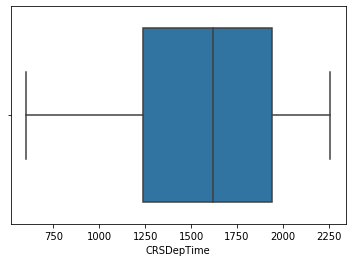

In [7]:
#Make a pair plot from the seaborn package
sea.boxplot(x=df["CRSDepTime"])

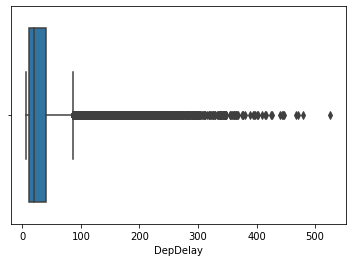

In [8]:
sea.boxplot(x=df["DepDelay"])

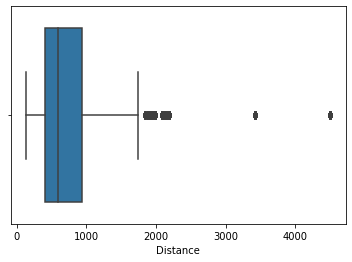

In [9]:
sea.boxplot(x=df["Distance"])

In [10]:
#correlation
correlated_df = df.corr()
print(correlated_df)

                DepDelay  CRSDepTime  Distance  CRSElapsedTime   Month_2  \
DepDelay        1.000000    0.148153 -0.028024       -0.023255 -0.012781   
CRSDepTime      0.148153    1.000000 -0.100908       -0.093877 -0.018289   
Distance       -0.028024   -0.100908  1.000000        0.994541  0.006248   
CRSElapsedTime -0.023255   -0.093877  0.994541        1.000000  0.013106   
Month_2        -0.012781   -0.018289  0.006248        0.013106  1.000000   
Month_3         0.008771    0.005907  0.005691        0.007872 -0.092854   
Month_4         0.015038   -0.013882  0.008028        0.005682 -0.076522   
Month_5        -0.042949    0.002985  0.014210        0.013217 -0.062610   
Month_6        -0.011332    0.041475  0.008843        0.004811 -0.086133   
Month_7         0.133603    0.042843  0.000072       -0.005362 -0.100239   
Month_8        -0.000545    0.021624 -0.003870       -0.007341 -0.084980   
Month_9        -0.047754   -0.020655 -0.007542       -0.010672 -0.065167   
Month_10    

### Related to predictors

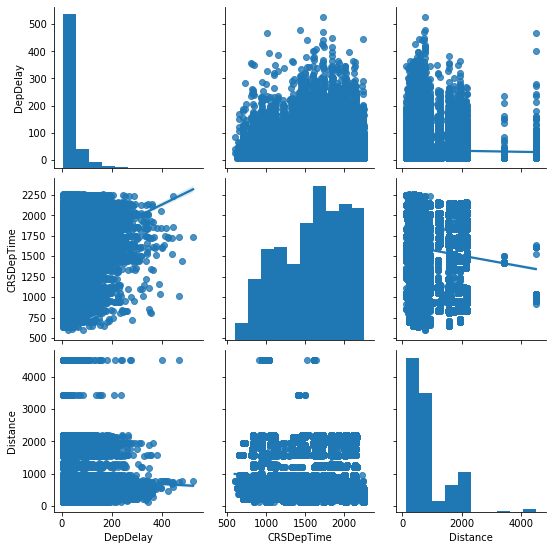

In [11]:
#Linear Relationship between predictors and response 
df_Assump = df[['DepDelay','CRSDepTime','Distance']].copy()
#Make a pair plot from the seaborn package
sea.pairplot(df_Assump, kind = "reg")
plt.show()

In [12]:
fig = px.scatter(df, x=df['CRSDepTime'], y="DepDelay")
fig.show()

In [13]:
fig = px.scatter(df, x=df['Distance'], y="DepDelay")
fig.show()

# Multiple Linear Regression

Text(0.5, 0, 'Distance')

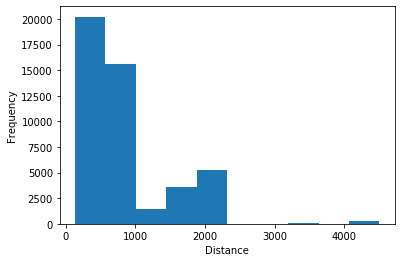

In [14]:
n, bins, patches = plt.hist(df["Distance"]) 
plt.ylabel('Frequency') 
plt.xlabel('Distance') 

Text(0.5, 0, 'CRSDepTime')

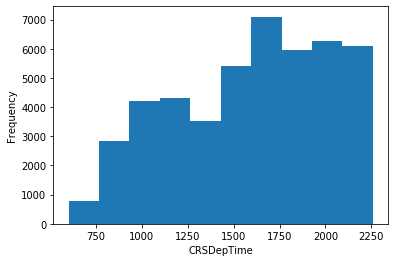

In [15]:
n, bins, patches = plt.hist(df["CRSDepTime"]) 
plt.ylabel('Frequency') 
plt.xlabel('CRSDepTime') 

In [16]:
dflog = df.copy() 
dflog[["CRSDepTime"]] = np.log(df[["CRSDepTime"]]+1) 
dflog[["Distance"]] = np.log(df[["Distance"]]+1) 

Text(0.5, 0, 'Distance')

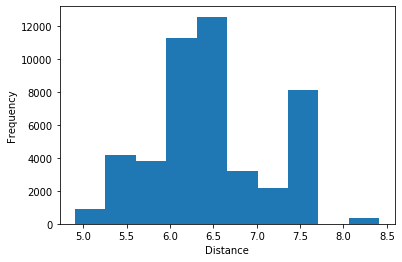

In [17]:
n, bins, patches = plt.hist(dflog["Distance"]) 
plt.ylabel('Frequency') 
plt.xlabel('Distance') 

Text(0.5, 0, 'CRSDepTime')

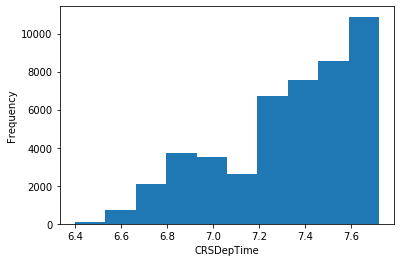

In [18]:
n, bins, patches = plt.hist(dflog["CRSDepTime"]) 
plt.ylabel('Frequency') 
plt.xlabel('CRSDepTime') 

In [19]:
df[["Distance"]] = np.log(df[["Distance"]]+1)

In [20]:
df = sm.add_constant(df)
#Make train/test spit
train, test = train_test_split(df, test_size=0.30)
lm_stats = sm.OLS(train["DepDelay"],train[["const","CRSDepTime","Distance","Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]]).fit()
pred_stats = lm_stats.predict(test[["const","CRSDepTime","Distance","Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]])
print("RMSE statsmodels: "+str(np.sqrt(mse(test[["DepDelay"]],pred_stats))))
print(lm_stats.summary())

RMSE statsmodels: 40.26995869964606
                            OLS Regression Results                            
Dep. Variable:               DepDelay   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     89.16
Date:                Wed, 02 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:17:40   Log-Likelihood:            -1.6686e+05
No. Observations:               32524   AIC:                         3.338e+05
Df Residuals:                   32504   BIC:                         3.339e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         

In [21]:
#Model with only intercept
lm_null = sm.OLS(train["DepDelay"],train[["const"]]).fit()

#One predictor models
lm_x1 = sm.OLS(train["DepDelay"],train[["const","CRSDepTime"]]).fit()
lm_x2 = sm.OLS(train["DepDelay"],train[["const","Distance"]]).fit()
lm_x3 = sm.OLS(train["DepDelay"],train[["const","Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12"]]).fit()
lm_x4 = sm.OLS(train["DepDelay"],train[["const","DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]]).fit()

#Two predictor models
lm_x1x2 = sm.OLS(train["DepDelay"],train[["const","CRSDepTime", "Distance"]]).fit()
lm_x1x3 = sm.OLS(train["DepDelay"],train[["const","CRSDepTime", "Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12"]]).fit()         
lm_x1x4 = sm.OLS(train["DepDelay"],train[["const","CRSDepTime", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]]).fit()         
lm_x2x3 = sm.OLS(train["DepDelay"],train[["const","Distance", "Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12"]]).fit() 
lm_x2x4 = sm.OLS(train["DepDelay"],train[["const","Distance", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]]).fit() 
lm_x3x4 = sm.OLS(train["DepDelay"],train[["const","Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]]).fit() 

#All predictors:
lm_all = sm.OLS(train["DepDelay"],train[["const","CRSDepTime","Distance","Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12","DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]]).fit()

#Extract all measures
results = pd.DataFrame(columns = ["Model","AIC", "BIC", "AdjR"])
results.Model = ["lm_null.aic", "lm_x1.aic", "lm_x2.aic", "lm_x3.aic", "lm_x4.aic","lm_x1x2.aic","lm_x1x3.aic", "lm_x1x4.aic",
                "lm_x2x3.aic", "lm_x2x4.aic", "lm_x3x4.aic", "lm_all.aic"]
results.AIC = [lm_null.aic, lm_x1.aic, lm_x2.aic, lm_x3.aic, lm_x4.aic,lm_x1x2.aic,lm_x1x3.aic, lm_x1x4.aic,
                lm_x2x3.aic, lm_x2x4.aic, lm_x3x4.aic, lm_all.aic]
results.BIC = [lm_null.bic, lm_x1.bic, lm_x2.bic, lm_x3.bic, lm_x4.bic,lm_x1x2.bic,lm_x1x3.bic, lm_x1x4.bic,
                lm_x2x3.bic, lm_x2x4.bic, lm_x3x4.bic, lm_all.bic]
results.AdjR = [lm_null.rsquared_adj, lm_x1.rsquared_adj, lm_x2.rsquared_adj,
        lm_x3.rsquared_adj, lm_x4.rsquared_adj,lm_x1x2.rsquared_adj,lm_x1x3.rsquared_adj, lm_x1x4.rsquared_adj,
                lm_x2x3.rsquared_adj, lm_x2x4.rsquared_adj, lm_x3x4.rsquared_adj, lm_all.rsquared_adj]
results

Model            AIC            BIC      AdjR
0   lm_null.aic  335377.361923  335385.751656  0.000000
1     lm_x1.aic  334661.070547  334677.850015  0.021813
2     lm_x2.aic  335357.021056  335373.800523  0.000656
3     lm_x3.aic  334692.829777  334793.506579  0.021158
4     lm_x4.aic  335121.919562  335180.647697  0.008006
5   lm_x1x2.aic  334660.276705  334685.445905  0.021867
6   lm_x1x3.aic  334025.970914  334135.037450  0.041053
7   lm_x1x4.aic  334440.255507  334507.373376  0.028611
8   lm_x2x3.aic  334674.132118  334783.198654  0.021751
9   lm_x2x4.aic  335102.911000  335170.028868  0.008616
10  lm_x3x4.aic  334390.229509  334541.244713  0.030402
11   lm_all.aic  333762.916643  333930.711314  0.048982

In [22]:
results[["AIC", "BIC"]].apply(np.min)

AIC    333762.916643
BIC    333930.711314
dtype: float64

In [23]:
results[["AdjR"]].apply(np.max)

AdjR    0.048982
dtype: float64

## Model selection with cross-validation

In [24]:
def calculate_rmse(X, y, nFold):    
    predictions = cross_val_predict(LinearRegression(fit_intercept=False), X, y, cv=nFold)
    rmse = sqrt(mse(y, predictions))
    return rmse

In [25]:
#Null model 
rmse_null = calculate_rmse(df[["const"]],df["DepDelay"],nFold=3) 
     
#One predictor models 
rmse_x1 = calculate_rmse(df[["const","CRSDepTime"]],df["DepDelay"],nFold=3) 
rmse_x2 = calculate_rmse(df[["const","Distance"]],df["DepDelay"],nFold=3)    
rmse_x3 = calculate_rmse(df[["const","Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12"]],df["DepDelay"],nFold=3) 
rmse_x4 = calculate_rmse(df[["const","DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]],df["DepDelay"],nFold=3)    
  
#Two predictor models 
rmse_x1x2 = calculate_rmse(df[["const", "CRSDepTime", "Distance"]],df["DepDelay"],nFold=3) 
rmse_x1x3 = calculate_rmse(df[["const", "CRSDepTime", "Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12"]],df["DepDelay"],nFold=3)   
rmse_x1x4 = calculate_rmse(df[["const", "CRSDepTime", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]],df["DepDelay"],nFold=3) 
rmse_x2x3 = calculate_rmse(df[["const", "Distance", "Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12"]],df["DepDelay"],nFold=3) 
rmse_x2x4 = calculate_rmse(df[["const", "Distance", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]],df["DepDelay"],nFold=3) 
rmse_x3x4 = calculate_rmse(df[["const", "Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]],df["DepDelay"],nFold=3) 

rmse_all = calculate_rmse(df[["const","CRSDepTime", "Distance", "Month_2","Month_3","Month_4","Month_5","Month_6","Month_7","Month_8","Month_9","Month_10","Month_11","Month_12", "DayOfWeek_2","DayOfWeek_3","DayOfWeek_4","DayOfWeek_5","DayOfWeek_6","DayOfWeek_7"]],df["DepDelay"],nFold=3) 
#Look at the best model 
rmse_null, rmse_x1, rmse_x2, rmse_x3, rmse_x4, rmse_x1x2, rmse_x1x3,rmse_x1x4, rmse_x2x3, rmse_x2x4,rmse_x3x4, rmse_all 

(41.91975288294874,
 41.4670590173132,
 41.9123330741463,
 2593365712707.889,
 42.25719570271031,
 41.46682896182704,
 41.680348333596015,
 41.808851814623644,
 5544742471882.615,
 42.25103806388271,
 3304795484796.5234,
 42.06098219518785)

## Check Assumptions again



In [26]:
#Extract the predictors and calculate the VIFs
variables = lm_all.model.exog
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif["Predictor"] = lm_all.model.exog_names

print(vif)

           VIF    Predictor
0   136.320297        const
1     1.024679   CRSDepTime
2     1.015553     Distance
3     1.918245      Month_2
4     2.365992      Month_3
5     2.004723      Month_4
6     1.689930      Month_5
7     2.202837      Month_6
8     2.528271      Month_7
9     2.180001      Month_8
10    1.770960      Month_9
11    2.095278     Month_10
12    2.073629     Month_11
13    2.485927     Month_12
14    1.592116  DayOfWeek_2
15    1.604582  DayOfWeek_3
16    1.695623  DayOfWeek_4
17    1.789827  DayOfWeek_5
18    1.578508  DayOfWeek_6
19    1.706510  DayOfWeek_7


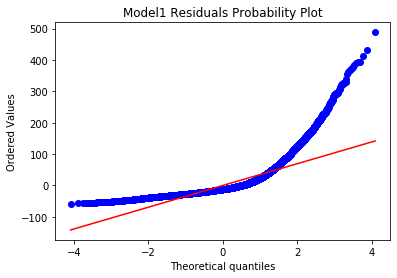

KstestResult(statistic=0.6558386064966701, pvalue=0.0)

In [27]:
#Make a QQ-plot of the residuals
stats.probplot(lm_all.resid, plot= plt)
plt.title("Model1 Residuals Probability Plot")
plt.show()

#Do a K-S test
stats.kstest(lm_all.resid, 'norm')

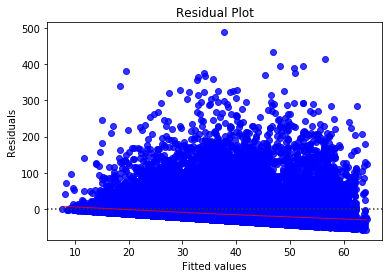

In [28]:
#Make a residual plot with the seaborn package
#Lowess adds a scatter smoother
plot_resid = sea.residplot(lm_all.fittedvalues, 'DepDelay', data=train, 
                          lowess=True,
                          scatter_kws={'color': 'blue'}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}
                          )

plot_resid.axes.set_title('Residual Plot')
plot_resid.axes.set_xlabel('Fitted values')
plot_resid.axes.set_ylabel('Residuals')

plt.show()

# Decision Tree

In [29]:
X = pd.DataFrame(df)
X = X.drop(['DepDelay'], axis=1)
y = pd.DataFrame(data=df['DepDelay'],columns=['DepDelay'])

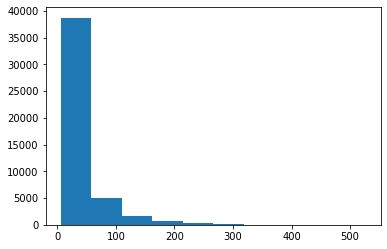

In [30]:
plt.hist(y.values)
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train,y_train)
prediction = decision_tree.predict(X_test)

print('RMSE:', np.sqrt(mse(y_test,prediction)))
print('Number of nodes:', decision_tree.tree_.node_count)

RMSE: 53.12184889089282
Number of nodes: 46159


In [32]:
decision_tree5 = DecisionTreeRegressor(max_depth=5,min_samples_leaf=10)
decision_tree5.fit(X_train,y_train)
prediction = decision_tree5.predict(X_test)

print('RMSE:', np.sqrt(mse(y_test,prediction)))
print('Number of nodes:', decision_tree5.tree_.node_count)

RMSE: 39.395845407129464
Number of nodes: 63


In [33]:
decision_tree6 = DecisionTreeRegressor(max_depth=6,min_samples_leaf=10)
decision_tree6.fit(X_train,y_train)
prediction = decision_tree6.predict(X_test)

print('RMSE:', np.sqrt(mse(y_test,prediction)))
print('Number of nodes:', decision_tree6.tree_.node_count)

RMSE: 39.35234044533591
Number of nodes: 121


In [34]:
decision_tree7 = DecisionTreeRegressor(max_depth=7,min_samples_leaf=10)
decision_tree7.fit(X_train,y_train)
prediction = decision_tree7.predict(X_test)

print('RMSE:', np.sqrt(mse(y_test,prediction)))
print('Number of nodes:', decision_tree7.tree_.node_count)

RMSE: 39.43897429942877
Number of nodes: 221


In [35]:
decision_tree8 = DecisionTreeRegressor(max_depth=8,min_samples_leaf=10)
decision_tree8.fit(X_train,y_train)
prediction = decision_tree8.predict(X_test)

print('RMSE:', np.sqrt(mse(y_test,prediction)))
print('Number of nodes:', decision_tree8.tree_.node_count)

RMSE: 39.75052706448809
Number of nodes: 379


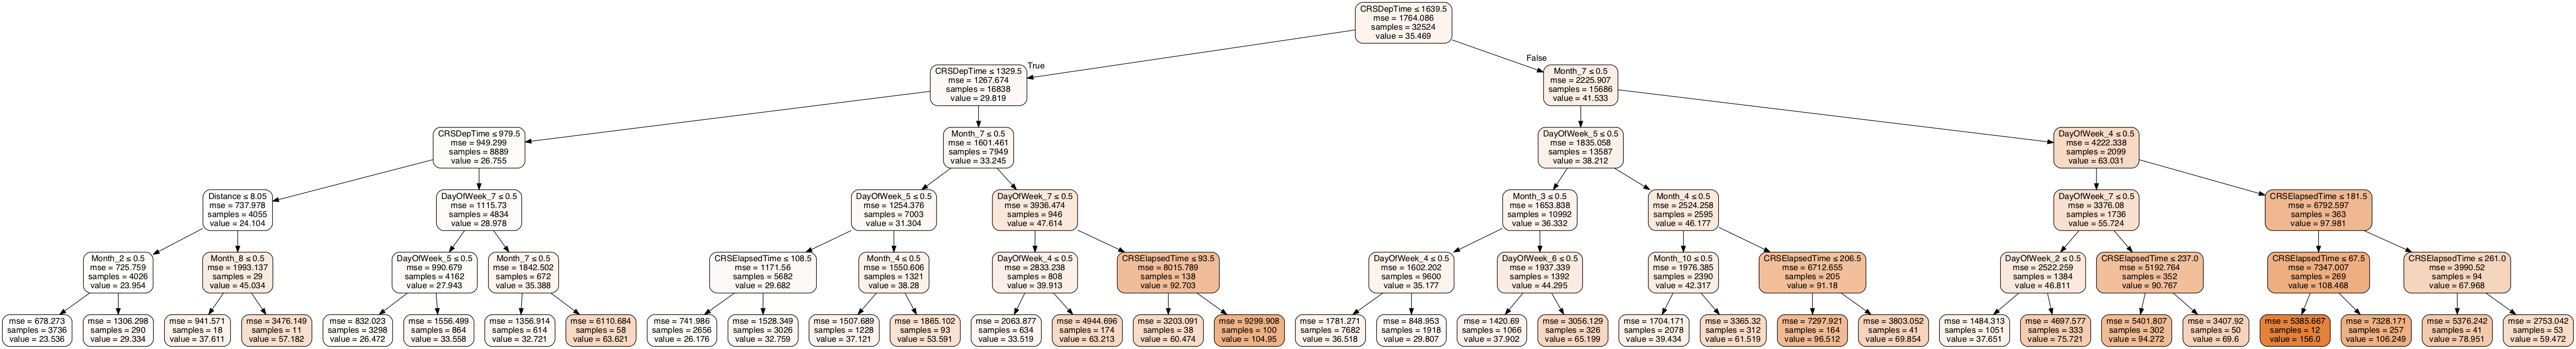

In [36]:
# create a file to store the figure in
dot_data = StringIO()
export_graphviz(decision_tree5, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X.columns)

# import and display the figure
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())